In [1]:
import tensorflow as tf
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.10.0


In [2]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [3]:
data = pd.read_csv('data/prod-licenses.csv')
data

,id,productid,serialnumber,authenticationcode,expirationdate,featuretype,licensekey,ismaintenancedisabled,maintenanceexpirationdate,newserial,...,company,customer,reseller,activationcount,saledate,isaccessunlimited,maxdaysbetweenconfirmations,datecreated,lastupdateddate,versionstamp
0,384ee3ca-8efe-47ac-b458-a8f2010c5655,de76fe0c-f6df-42e0-8fdc-a37000b6c6e3,R30015832,77A236D8EAC838A4BCE9C57A189EFC7B,NaN,4398096859266,NaN,f,2019-06-01 00:00:00,NaN,...,Green River Community College,Kieran Raney / IT Purchasing,NaN,1,2018-06-01 16:16:48,f,60,2018-06-01 16:16:59,2022-08-08 18:47:24,312
1,43a77943-f4ec-4f1a-9f51-a6db009802b2,d1d14ba1-ef6c-47ce-9bd2-a44200d6498b,R20600133,566ACE0C64B6172B050A723AA78647FD,NaN,4398096859266,N6P0-55FQ-L69G-M9A7,f,2017-12-13 00:00:00,NaN,...,Uni Oldenburg,Uni Oldenburg,PKI,1,2016-12-13 14:12:56,f,60,2016-12-13 14:13:27,2016-12-13 14:13:27,1
2,807453fe-b20b-4825-ad3e-a6db009b79e0,d1d14ba1-ef6c-47ce-9bd2-a44200d6498b,R20600134,6C510637216D1F2A7C37D32D381EFCB4,NaN,4398096859266,KFP3-7YN2-A0LR-086W,f,2017-12-13 00:00:00,NaN,...,Uni Potsdam,Uni Potsdam,PKI,1,2016-12-13 14:25:50,f,60,2016-12-13 14:26:04,2016-12-13 14:26:04,1
3,16bf1d4f-9aaf-4a9f-8d00-a6db009dfdcb,1fe090bc-0e4f-418d-9dbd-a62000ce8992,R21800006,6E0DE020297D2C7A81704EF5E69679A1,2016-12-27 00:00:00,4398096859266,VVH3-4U7P-LXYJ-UXDY,f,2016-12-13 00:00:00,NaN,...,Sodexo Entegre Hizmet Yönetimi A.Ş - VOID,Sodexo Entegre Hizmet Yönetimi A.Ş - VOID,Arai Teknoloji,1,2016-12-13 13:59:25,f,60,2016-12-13 14:35:13,2016-12-13 14:35:13,1
4,703ef0b3-c485-4413-a728-af1d00a99656,d1d14ba1-ef6c-47ce-9bd2-a44200d6498b,R20600450,CEFEE84B9370AC0AB8479CA661C1EC01,NaN,4398096859266,NaN,f,2023-09-27 00:00:00,NaN,...,Uni Basel DSBG,Uni Basel DSBG,PKI,1,2022-09-27 14:17:18,f,120,2022-09-27 14:17:26,2023-07-17 22:47:58,345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21758,341dca66-1bd4-407d-a950-a71a014b7fc5,c0d10801-0abb-45b4-9820-a41701262ef0,R20100175,489389DFABA08C75605E17FD779E62A9,NaN,4398096859266,QWTR-G4E0-LCRQ-YX18,f,2019-02-09 00:00:00,NaN,...,Colegio Espirito Santo,Colegio Espirito Santo,GB Network & Print,1,2017-02-14 20:06:54,f,60,2017-02-14 20:06:57,2023-05-22 18:04:25,200
21759,527e2d85-9861-4ea0-b55b-a38600cb9f33,de76fe0c-f6df-42e0-8fdc-a37000b6c6e3,R30011352,107E04AC6F27D66D3E7E93D0040DEFB5,NaN,4398096859266,8G2T-LKY0-PFP4-5H5D,f,2023-05-19 00:00:00,NaN,...,Univ KL Royal College of Medicine Perak,Univ KL Royal College of Medicine Perak,Scansys,1,2015-03-17 17:14:14,f,60,2014-08-13 16:21:21,2023-07-07 07:41:31,356
21760,1b10a205-80f2-40de-baba-a5e000a1b18a,f488ef9b-b814-4f9b-abb4-a49800c75819,R21800065,173A59F1B9CD1CBA5BE294CBE2F7D9CC,NaN,4398096859266,J03T-RUE7-MER7-MYC2,f,2019-04-06 00:00:00,NaN,...,Mesfr/Altaeef customer,Mesfr/Altaeef customer,Computek International,1,2016-04-06 13:48:18,f,60,2016-04-06 13:48:42,2023-06-22 06:34:38,2234
21761,1f51aac5-3397-4363-8cb4-accb00950734,c0d10801-0abb-45b4-9820-a41701262ef0,R20100606,5BD928057A297595B9A923B0B045C897,NaN,4398096859266,NaN,f,2023-12-14 00:00:00,NaN,...,Grupo Kosmoscience,Grupo Kosmoscience Ciencia e Tecnologia,GB Network & Print,1,2020-12-03 15:52:37,f,120,2021-02-10 14:02:35,2023-07-18 16:49:08,2136


In [4]:
time.mktime(datetime.datetime.strptime(data['saledate'][0], '%Y-%m-%d %H:%M:%S')\
    .timetuple())



1527884208.0

In [5]:
def saledate_to_timestamp(saledate):
    if not isinstance(saledate, str): return saledate
    return datetime.date.fromisoformat(saledate[:10])

def date_to_weekday(date):
    if not isinstance(date, datetime.date): return date
    return date.timetuple().tm_wday

data['saledate'] = data['saledate'].apply(saledate_to_timestamp)
data['day_of_week'] = data['saledate'].apply(date_to_weekday)
data

,id,productid,serialnumber,authenticationcode,expirationdate,featuretype,licensekey,ismaintenancedisabled,maintenanceexpirationdate,newserial,...,customer,reseller,activationcount,saledate,isaccessunlimited,maxdaysbetweenconfirmations,datecreated,lastupdateddate,versionstamp,day_of_week
0,384ee3ca-8efe-47ac-b458-a8f2010c5655,de76fe0c-f6df-42e0-8fdc-a37000b6c6e3,R30015832,77A236D8EAC838A4BCE9C57A189EFC7B,NaN,4398096859266,NaN,f,2019-06-01 00:00:00,NaN,...,Kieran Raney / IT Purchasing,NaN,1,2018-06-01,f,60,2018-06-01 16:16:59,2022-08-08 18:47:24,312,4.0
1,43a77943-f4ec-4f1a-9f51-a6db009802b2,d1d14ba1-ef6c-47ce-9bd2-a44200d6498b,R20600133,566ACE0C64B6172B050A723AA78647FD,NaN,4398096859266,N6P0-55FQ-L69G-M9A7,f,2017-12-13 00:00:00,NaN,...,Uni Oldenburg,PKI,1,2016-12-13,f,60,2016-12-13 14:13:27,2016-12-13 14:13:27,1,1.0
2,807453fe-b20b-4825-ad3e-a6db009b79e0,d1d14ba1-ef6c-47ce-9bd2-a44200d6498b,R20600134,6C510637216D1F2A7C37D32D381EFCB4,NaN,4398096859266,KFP3-7YN2-A0LR-086W,f,2017-12-13 00:00:00,NaN,...,Uni Potsdam,PKI,1,2016-12-13,f,60,2016-12-13 14:26:04,2016-12-13 14:26:04,1,1.0
3,16bf1d4f-9aaf-4a9f-8d00-a6db009dfdcb,1fe090bc-0e4f-418d-9dbd-a62000ce8992,R21800006,6E0DE020297D2C7A81704EF5E69679A1,2016-12-27 00:00:00,4398096859266,VVH3-4U7P-LXYJ-UXDY,f,2016-12-13 00:00:00,NaN,...,Sodexo Entegre Hizmet Yönetimi A.Ş - VOID,Arai Teknoloji,1,2016-12-13,f,60,2016-12-13 14:35:13,2016-12-13 14:35:13,1,1.0
4,703ef0b3-c485-4413-a728-af1d00a99656,d1d14ba1-ef6c-47ce-9bd2-a44200d6498b,R20600450,CEFEE84B9370AC0AB8479CA661C1EC01,NaN,4398096859266,NaN,f,2023-09-27 00:00:00,NaN,...,Uni Basel DSBG,PKI,1,2022-09-27,f,120,2022-09-27 14:17:26,2023-07-17 22:47:58,345,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21758,341dca66-1bd4-407d-a950-a71a014b7fc5,c0d10801-0abb-45b4-9820-a41701262ef0,R20100175,489389DFABA08C75605E17FD779E62A9,NaN,4398096859266,QWTR-G4E0-LCRQ-YX18,f,2019-02-09 00:00:00,NaN,...,Colegio Espirito Santo,GB Network & Print,1,2017-02-14,f,60,2017-02-14 20:06:57,2023-05-22 18:04:25,200,1.0
21759,527e2d85-9861-4ea0-b55b-a38600cb9f33,de76fe0c-f6df-42e0-8fdc-a37000b6c6e3,R30011352,107E04AC6F27D66D3E7E93D0040DEFB5,NaN,4398096859266,8G2T-LKY0-PFP4-5H5D,f,2023-05-19 00:00:00,NaN,...,Univ KL Royal College of Medicine Perak,Scansys,1,2015-03-17,f,60,2014-08-13 16:21:21,2023-07-07 07:41:31,356,1.0
21760,1b10a205-80f2-40de-baba-a5e000a1b18a,f488ef9b-b814-4f9b-abb4-a49800c75819,R21800065,173A59F1B9CD1CBA5BE294CBE2F7D9CC,NaN,4398096859266,J03T-RUE7-MER7-MYC2,f,2019-04-06 00:00:00,NaN,...,Mesfr/Altaeef customer,Computek International,1,2016-04-06,f,60,2016-04-06 13:48:42,2023-06-22 06:34:38,2234,2.0
21761,1f51aac5-3397-4363-8cb4-accb00950734,c0d10801-0abb-45b4-9820-a41701262ef0,R20100606,5BD928057A297595B9A923B0B045C897,NaN,4398096859266,NaN,f,2023-12-14 00:00:00,NaN,...,Grupo Kosmoscience Ciencia e Tecnologia,GB Network & Print,1,2020-12-03,f,120,2021-02-10 14:02:35,2023-07-18 16:49:08,2136,3.0


In [6]:
office_guids = [
    "f488ef9b-b814-4f9b-abb4-a49800c75819",
    "de76fe0c-f6df-42e0-8fdc-a37000b6c6e3",
    "d1d14ba1-ef6c-47ce-9bd2-a44200d6498b",
    "3d9d15e0-a4c6-4de5-ad88-a62000ceeccd",
    "c0d10801-0abb-45b4-9820-a41701262ef0",
    "182db722-90e1-465b-a278-a5da00a51cfa",
    "1fe090bc-0e4f-418d-9dbd-a62000ce8992"
]

data_office = data.loc[data['productid'].isin(office_guids)]

# drop 2023 outlier
data_office = data_office.loc[data_office['saledate'] <= datetime.date(2023,1,1)]
data_office['saledate'].array[0]

datetime.date(2018, 6, 1)

In [7]:
# add day of year column, then sin/cos signals
data_office['day_of_year'] = data_office['saledate'].apply(lambda x: x.timetuple().tm_yday)
data_office['year_sin'] = np.sin(data_office['day_of_year'].apply(lambda x: x * (2 * np.pi / 365)))
data_office['year_cos'] = np.cos(data_office['day_of_year'].apply(lambda x: x * (2 * np.pi / 365)))

data_office.columns

Index(['id', 'productid', 'serialnumber', 'authenticationcode',
       'expirationdate', 'featuretype', 'licensekey', 'ismaintenancedisabled',
       'maintenanceexpirationdate', 'newserial', 'newauthentication', 'type',
       'company', 'customer', 'reseller', 'activationcount', 'saledate',
       'isaccessunlimited', 'maxdaysbetweenconfirmations', 'datecreated',
       'lastupdateddate', 'versionstamp', 'day_of_week', 'day_of_year',
       'year_sin', 'year_cos'],
      dtype='object')

In [8]:
sale_counts = data_office.groupby(data['saledate'])['activationcount'].count()

grouped_data = pd.DataFrame({'sale_counts': sale_counts})

In [9]:
# Add zeros in data

add_day = datetime.timedelta(days=1)

current_date = sale_counts.index.min()
max_date = sale_counts.index.max()

while current_date < max_date:
    if current_date not in grouped_data.index:
        grouped_data = pd.concat([grouped_data, pd.DataFrame({'sale_counts': 0},index=[current_date])])
    current_date += add_day
    
grouped_data = grouped_data.sort_index()

grouped_data['day_of_week_sin'] = np.sin(grouped_data.index.map(lambda x: x.timetuple().tm_wday * (2 * np.pi / 7)))
grouped_data['day_of_week_cos'] = np.cos(grouped_data.index.map(lambda x: x.timetuple().tm_wday * (2 * np.pi / 7)))
grouped_data['is_weekday'] = grouped_data.index.map(lambda x: 1 if 1 <= x.timetuple().tm_wday <= 5 else 0)

grouped_data

,sale_counts,day_of_week_sin,day_of_week_cos,is_weekday
2014-05-21,1,0.974928,-0.222521,1
2014-05-22,1,0.433884,-0.900969,1
2014-05-23,2,-0.433884,-0.900969,1
2014-05-24,0,-0.974928,-0.222521,1
2014-05-25,0,-0.781831,0.623490,0
...,...,...,...,...
2022-12-26,0,0.000000,1.000000,0
2022-12-27,0,0.781831,0.623490,1
2022-12-28,0,0.974928,-0.222521,1
2022-12-29,0,0.433884,-0.900969,1


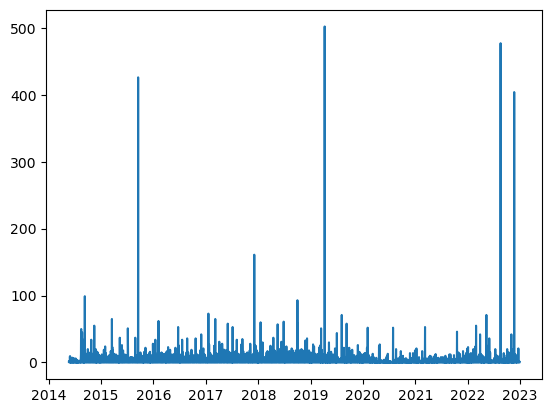

In [10]:
x = grouped_data.index
y = grouped_data['sale_counts'].array

plt.plot(x,y)

Text(0.5, 1.0, 'FFT of License Creations by Day')

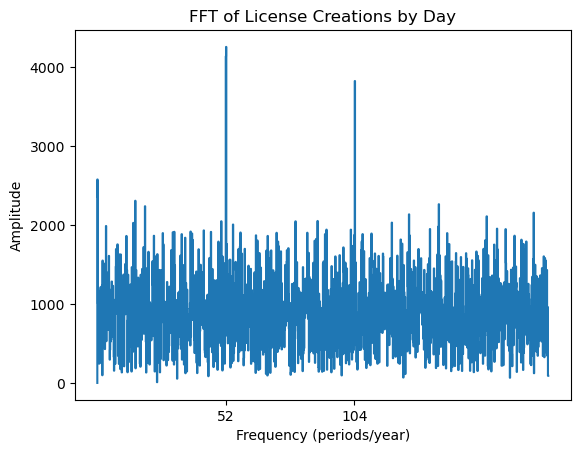

In [13]:
# mean center
grouped_data_centered = grouped_data - grouped_data.mean()

fft = np.abs(np.fft.rfft(grouped_data_centered['sale_counts'].array))

f_per_dataset = np.arange(0,len(fft))
n_samples_d = len(grouped_data_centered)
days_per_year = 365
years_per_dataset = n_samples_d / days_per_year

f_per_year = f_per_dataset / years_per_dataset

plt.step(f_per_year, fft)
plt.xticks([52,104])
plt.xlabel('Frequency (periods/year)')
plt.ylabel('Amplitude')
plt.title('FFT of License Creations by Day')

In [12]:
n = len(grouped_data)
train_df = grouped_data[0:int(n*0.7)]
val_df = grouped_data[int(n*0.7):int(n*0.9)]
test_df = grouped_data[int(n*0.9):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
single_step_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['sale_counts'])
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['sale_counts']

In [2]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [3]:
linear